### State of the art transfer learning method for Image Classification
<br>
<br>



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

SEEDS = 42

np.random.seed(SEEDS)
tf.random.set_seed(SEEDS)

In [2]:
# Get the dataset

train_ds, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True,
)

Dataset tf_flowers downloaded and prepared to ~/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


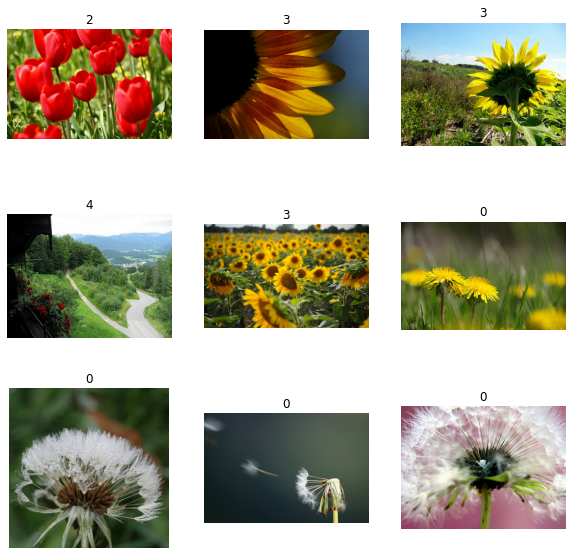

In [3]:
# visualising the dataset

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(image)
  plt.title(int(label))
  plt.axis("off")

In [4]:
RESIZE_TO = 384
CROP_TO = 224
BATCH_SIZE = 64
STEPS_PER_EPOCH = 10
AUTO = tf.data.AUTOTUNE  # optimise the pipeline performance
NUM_CLASSES = 5 
SCHEDULE_LENGTH = (
    500  # we will train on lower resolution images and will still attain good results
)
SCHEDULE_BOUNDARIES = [
    200,
    300,
    400,
]  # more the dataset size the schedule length increase

In [5]:
# preprocessing functions

SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE

@tf.function     # generates tf.graph of below function computations to speedup processing
def preprocess_train(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.resize(image, (RESIZE_TO, RESIZE_TO))
  image = tf.image.random_crop(image, (CROP_TO, CROP_TO, 3))
  image = image / 255.0
  return(image, label)

@tf.function
def preprocess_test(image, label):
  image = tf.image.resize(image, (RESIZE_TO, RESIZE_TO))
  image = image / 255.0
  return (image, label)

DATASET_NUM_TRAIN_EXAMPLES = train_ds.cardinality().numpy()

repeat_count = int(
    SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH
)
repeat_count += 50 + 1     # To ensure at least there are 50 epochs of training

### Data pipeline

In [7]:
# Training pipeline
pipeline_train = (
    train_ds.shuffle(10000)
    .repeat(repeat_count)
    .map(preprocess_train, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Validation pipeline
pipeline_validation = (
    validation_ds.map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

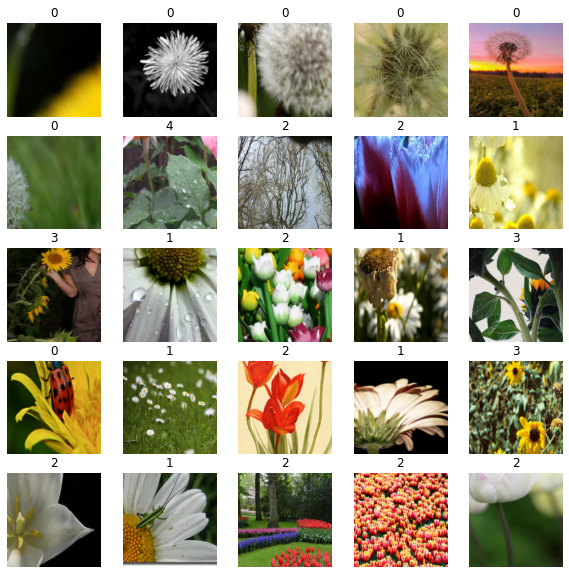

In [13]:
# Visualise the training samples

image_batch, label_batch = next(iter(pipeline_train))

plt.figure(figsize=(10, 10))
for n in range(25):
  ax = plt.subplot(5, 5, n+1)
  plt.imshow(image_batch[n])
  plt.title(label_batch[n].numpy())
  plt.axis("off")

In [14]:
# load pre-trained TF-HUB model into a keras layer

bit_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
bit_module = hub.KerasLayer(bit_model_url)

In [15]:
# create BigT model

class MyBiTModel(keras.Model):
  def __init__(self, num_classes, module, **kwargs):
    super().__init__(**kwargs)
    
    self.num_classes = num_classes
    self.head = keras.layers.Dense(num_classes, kernel_initializer="zeros")
    self.bit_model = module
    
  def call(self, images):
    bit_embedding = self.bit_model(images)
    return self.head(bit_embedding)  

model = MyBiTModel(num_classes=NUM_CLASSES, module=bit_module)    

In [16]:
# Define optimizer and loss

learning_rate = 0.003 * BATCH_SIZE / 512

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES,
    values=[
        learning_rate,
        learning_rate * 0.1,
        learning_rate * 0.01,
        learning_rate * 0.001,
    ],
)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [18]:
# Compile the model
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

In [19]:
# Set-up callbacks
train_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=2, restore_best_weights=True
    )
]

In [21]:
# Train the model

history = model.fit(
    pipeline_train,
    batch_size=BATCH_SIZE,
    epochs=int(SCHEDULE_LENGTH / STEPS_PER_EPOCH),
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=pipeline_validation,
    callbacks=train_callbacks,
)

Epoch 1/400
10/10 [==============================] - 14s 1s/step - loss: 0.1075 - accuracy: 0.9656 - val_loss: 0.0779 - val_accuracy: 0.9836
Epoch 2/400
10/10 [==============================] - 13s 1s/step - loss: 0.1467 - accuracy: 0.9500 - val_loss: 0.0739 - val_accuracy: 0.9800
Epoch 3/400
10/10 [==============================] - 14s 1s/step - loss: 0.1001 - accuracy: 0.9672 - val_loss: 0.0852 - val_accuracy: 0.9745


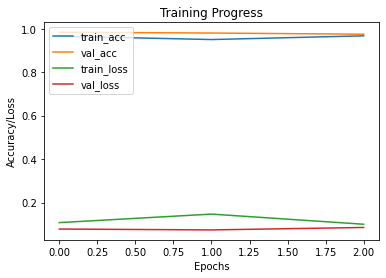

In [22]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend(["train_acc", "val_acc", "train_loss", "val_loss"], loc="upper left")
    plt.show()


plot_hist(history)

In [23]:
# Evaluate the model
accuracy = model.evaluate(pipeline_validation)[1]*100
print("Accuracy: {:.2f}%".format(accuracy))

9/9 [==============================] - 9s 1s/step - loss: 0.0779 - accuracy: 0.9836
Accuracy: 98.36%
